In [ ]:
!pip install tsai

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
INFO: pip is looking at multiple versions of torchvision to

In [ ]:
!pip3 install mamba-ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 3.9 MB/s eta 0:00:00
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.2-cp310-cp310-linux_x86_64.whl size=323764006 sha256=da568f0150541cd783b54513be10ae5f491a71a58dbd423d93fe2d76e82a25f6
  Stored in directory: /root/.cache/pip/wheels/57/7c/90/9f963468ecc3791e36e388f9e7b4a4e1e3f90fbb340055aa4d
Successfully built mamba-ssm


## Import Clean Data

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import torch

pd.options.mode.chained_assignment = None

In [ ]:
# This will prompt you to authorize access to your Google Drive
drive.mount('/content/drive')

# Now you can access files from your Google Drive
df = pd.read_csv('/content/drive/MyDrive/data_files/preprocessed_data.csv')

Mounted at /content/drive


## Define TST and Mamba Model

In [ ]:
import torch
import torch.nn as nn
from tsai.models.TST import TST

class TimeSeriesTransformerWithTST(nn.Module):
    def __init__(self, c_in, c_out, seq_len):
        super(TimeSeriesTransformerWithTST, self).__init__()
        self.tst = TST(c_in, c_out, seq_len)

    def forward(self, src):
        src = src.transpose(2,1).contiguous()
        output = self.tst(src)
        return output

In [ ]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba
import math

def seed_everything(seed):
    # Set the random seed manually for reproducibility.
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(0)

class TimeSeriesMamba(nn.Module):
    def __init__(self, feature_size, num_hidden, num_layers, num_classes):
        super(TimeSeriesMamba, self).__init__()
        # Initialize Mamba with appropriate dimensions
        self.num_layers = num_layers
        self.mamba_list = nn.ModuleList()
        self.norm_list = nn.ModuleList()
        self.dropout_list = nn.ModuleList()

        for i in range(num_layers):
            m = Mamba(
              d_model=feature_size,  # Model dimension
              d_state=16,            # SSM state expansion factor
              d_conv=4,              # Local convolution width
              expand=2,              # Block expansion factor
            )
            self.mamba_list.append(m)

            self.norm_list.append(nn.LayerNorm(feature_size))

            self.dropout_list.append(nn.Dropout(0.1))

        self.fc = nn.Linear(feature_size, num_classes)

    def forward(self, src):
        for i in range(self.num_layers):
          src = src + self.mamba_list[i](src)
          src = self.norm_list[i](src)

        # output = self.mamba(src)
        output = torch.mean(src, dim=1)
        output = self.fc(output)
        return output

In [ ]:
def train_model(model, train_X, train_y, val_X, val_y, epochs=20, lr=0.001, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Ensure tensors are on the correct device
    train_X = train_X.to(device)
    train_y = train_y.to(device)
    val_X = val_X.to(device)
    val_y = val_y.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        output = model(train_X)
        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_output = model(val_X)
            val_loss = criterion(val_output, val_y)
            val_losses.append(val_loss.item())

        # print(f'Epoch {epoch + 1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            # print(f'Early stopping triggered after {epoch + 1} epochs.')
            break

    return train_losses, val_losses


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate_accuracy(model, test_X, test_y):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(test_X)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == test_y).sum().item()
        total = test_y.size(0)
        accuracy = correct / total
    return accuracy, predicted

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(10, 8))
    display_labels = ["No Exercise", "Exercise"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    disp = disp.plot(include_values=True,
                     cmap=plt.cm.Blues, ax=ax)
    ax.set_title(title)
    plt.show()

## Add Granular Data

In [ ]:
# Now you can access files from your Google Drive
df_five_minutes = pd.read_csv('/content/drive/MyDrive/five_minute_group_cgm_data.csv')
df_five_minutes.drop("Unnamed: 0", axis=1, inplace=True)
df_five_minutes = pd.merge(df, df_five_minutes, on=['Participant', 'Date']).drop("Date",axis=1)
df_five_minutes = df_five_minutes.drop("Time", axis=1)
df_five_minutes

,Participant,Feature1,Feature2,Feature3,Feature4,Day,Sick,Morning Fear of Hypoglycemia,Evening Fear of Hypoglycemia,Sleep Quality,...,Participant_17,Participant_18,Participant_19,Participant_20,Participant_21,Participant_23,IsAsleep,Weekday,IsWeekend,CGM
0,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,100.0
1,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,106.0
2,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,120.0
3,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,122.0
4,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75812,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,True,0,0,123.0
75813,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,False,0,0,149.0
75814,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,False,0,0,148.0
75815,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,False,0,0,154.0


In [ ]:
# Now you can access files from your Google Drive
df_one_hour = pd.read_csv('/content/drive/MyDrive/one_hour_group_cgm_data.csv')
df_one_hour.drop("Unnamed: 0", axis=1, inplace=True)
df_one_hour = pd.merge(df, df_one_hour, on=['Participant', 'Date']).drop("Date",axis=1)
df_one_hour = df_one_hour.drop("Time", axis=1)
df_one_hour

,Participant,Feature1,Feature2,Feature3,Feature4,Day,Sick,Morning Fear of Hypoglycemia,Evening Fear of Hypoglycemia,Sleep Quality,...,Participant_17,Participant_18,Participant_19,Participant_20,Participant_21,Participant_23,IsAsleep,Weekday,IsWeekend,CGM
0,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,109.916667
1,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,93.000000
2,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,103.000000
3,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,150.916667
4,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,False,0,0,105.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,False,0,0,147.750000
6897,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,False,0,0,156.916667
6898,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,True,0,0,95.500000
6899,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,True,0,0,140.916667


In [ ]:
# Now you can access files from your Google Drive
df_one_minute = pd.read_csv('/content/drive/MyDrive/minutely_group_cgm_data.csv')
df_one_minute.drop("Unnamed: 0", axis=1, inplace=True)
df_one_minute = pd.merge(df, df_one_minute, on=['Participant', 'Date']).drop("Date",axis=1)
df_one_minute = df_one_minute.drop("Time", axis=1)
df_one_minute

,Participant,Feature1,Feature2,Feature3,Feature4,Day,Sick,Morning Fear of Hypoglycemia,Evening Fear of Hypoglycemia,Sleep Quality,...,Participant_17,Participant_18,Participant_19,Participant_20,Participant_21,Participant_23,IsAsleep,Weekday,IsWeekend,CGM
0,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,100.0
1,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,100.0
2,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,109.0
3,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,82.0
4,11,0.0,0.0,0.0,0.0,1,0,1,1,5.0,...,False,False,False,False,False,False,True,0,0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379023,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,True,0,0,157.0
379024,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,True,0,0,157.0
379025,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,True,0,0,157.0
379026,19,0.0,0.0,0.0,0.0,68,0,3,1,10.0,...,False,False,True,False,False,False,True,0,0,157.0


## Main Exploration Loop

In [ ]:
def generate_data_with_window(df, window_size, exclude_feature=None):
    features = df.drop(columns=['Day', 'Participant', 'y'])  # Exclude non-feature and non-participant columns
    if exclude_feature:
        features = features.drop(columns=[exclude_feature])  # Optionally exclude a specific feature

    labels = df['y']
    participants = df['Participant']

    sequences = []
    labels_out = []
    participants_out = []

    for i in range(len(df) - window_size + 1):
        # Check if all entries in the window belong to the same participant
        if len(set(participants.iloc[i:i + window_size])) == 1:
            window = features.iloc[i:i + window_size]  # Create a window of the specified size
            label = labels.iloc[i + window_size - 1]  # Get the label from the end of the window
            participant_id = participants.iloc[i]  # Participant ID for this window

            sequences.append(window.values)
            labels_out.append(label)
            participants_out.append(participant_id)

    sequences_np = np.array(sequences)
    labels_np = np.array(labels_out)
    participants_np = np.array(participants_out)
    return sequences_np, labels_np, participants_np


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np

# Define the DataFrame to store results
res_df = pd.DataFrame(columns=['Window Size', 'Excluded Feature', 'Granular Size', 'Average Accuracy', 'Standard Deviation'])

def train_and_evaluate_model(df, window_size, granular_size, exclude_feature=None):
    sequences_np, labels_np, participant_groups = generate_data_with_window(df, window_size, exclude_feature)
    feature_size = sequences_np.shape[2]  # Updated dynamically based on left-out features

    # Ensure all data is float32 for compatibility with PyTorch
    sequences_np = sequences_np.astype(np.float32)
    labels_np = labels_np.astype(np.int64)

    # Instantiate the model with the dynamic number of features
    PatchTST_model = TimeSeriesTransformerWithTST(c_in=feature_size, c_out=2, seq_len=window_size).to("cuda")

    # Define 5-fold cross-validation with GroupKFold
    gkf = GroupKFold(n_splits=5)

    fold_accuracies = []
    cm_sum = np.zeros((2, 2), dtype=np.int64)

    for fold, (train_idx, val_idx) in enumerate(gkf.split(sequences_np, labels_np, participant_groups), 1):
        X_train_fold, y_train_fold = sequences_np[train_idx], labels_np[train_idx]
        X_val_fold, y_val_fold = sequences_np[val_idx], labels_np[val_idx]

        # Flatten X_train_fold for SMOTE
        X_train_fold_flattened = X_train_fold.reshape(X_train_fold.shape[0], -1)
        smote = SMOTE(random_state=42)
        X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold_flattened, y_train_fold)
        X_train_fold_res = X_train_fold_resampled.reshape(-1, window_size, feature_size)

        # Convert to PyTorch tensors, ensuring all data is on the CUDA device
        train_X_fold = torch.tensor(X_train_fold_res, dtype=torch.float32).to("cuda")
        train_y_fold = torch.tensor(y_train_fold_resampled, dtype=torch.long).to("cuda")
        val_X_fold = torch.tensor(X_val_fold, dtype=torch.float32).to("cuda")
        val_y_fold = torch.tensor(y_val_fold, dtype=torch.long).to("cuda")

        # Train and evaluate the model
        train_losses, val_losses = train_model(PatchTST_model, train_X_fold, train_y_fold, val_X_fold, val_y_fold, epochs=100, lr=0.001, patience=20)
        test_accuracy, predicted_labels = evaluate_accuracy(PatchTST_model, val_X_fold, val_y_fold)

        fold_accuracies.append(test_accuracy)
        cm = confusion_matrix(val_y_fold.cpu().numpy(), predicted_labels.cpu().numpy())
        cm_sum += cm

    average_accuracy = np.mean(fold_accuracies)
    std_dev = np.std(fold_accuracies)

    print(f"Accuracy for window {window_size} excluding '{exclude_feature}': {average_accuracy:.4f} ± {std_dev:.4f}")

    result = {
        'Window Size': window_size,
        'Excluded Feature': exclude_feature,
        'Granular Size': granular_size,
        'Average Accuracy': f"{average_accuracy:.4f}",
        'Standard Deviation': f"{std_dev:.4f}"
    }
    return result

In [ ]:
df.drop('Date', axis=1, inplace=True)

In [ ]:
# Example usage in the outer loop
granular_sizes = ["hourly", "daily"]
for indx, curr_df in enumerate([df_one_hour, df]):
  for window_size in [1,2,3,4]:  # Example window sizes
      for feature in curr_df.columns.difference(['Day', 'Participant', 'y']):
        if feature.startswith("Participant_"):
          continue
        print(f"Processing with window size {window_size} days at granular {granular_sizes[indx]} and excluding {feature}")
        if "hourly" in granular_sizes[indx]:
          result = train_and_evaluate_model(curr_df, window_size * 24, granular_sizes[indx], exclude_feature=feature)
        else:
          result = train_and_evaluate_model(curr_df, window_size, granular_sizes[indx], exclude_feature=feature)

        res_df = pd.concat([res_df, pd.DataFrame([result])], ignore_index=True)
res_df

Processing with window size 1 days at granular hourly and excluding # of times hypoglycemic
Accuracy for window 24 excluding '# of times hypoglycemic': 0.6783 ± 0.1470
Processing with window size 1 days at granular hourly and excluding Age
Accuracy for window 24 excluding 'Age': 0.6044 ± 0.1860
Processing with window size 1 days at granular hourly and excluding BMI
Accuracy for window 24 excluding 'BMI': 0.6454 ± 0.1743
Processing with window size 1 days at granular hourly and excluding CGM
Accuracy for window 24 excluding 'CGM': 0.6824 ± 0.1698
Processing with window size 1 days at granular hourly and excluding CV_daytime
Accuracy for window 24 excluding 'CV_daytime': 0.6504 ± 0.1742
Processing with window size 1 days at granular hourly and excluding CV_nighttime
Accuracy for window 24 excluding 'CV_nighttime': 0.6294 ± 0.1916
Processing with window size 1 days at granular hourly and excluding CV_total
Accuracy for window 24 excluding 'CV_total': 0.7245 ± 0.1973
Processing with window

,Window Size,Excluded Feature,Granular Size,Average Accuracy,Standard Deviation
0,96,# of times hypoglycemic,hourly,0.5830,0.1814
1,24,# of times hypoglycemic,hourly,0.6783,0.1470
2,24,Age,hourly,0.6044,0.1860
3,24,BMI,hourly,0.6454,0.1743
4,24,CGM,hourly,0.6824,0.1698
...,...,...,...,...,...
508,4,dayOfWeek_2,daily,0.7539,0.1021
509,4,dayOfWeek_3,daily,0.7465,0.0831
510,4,dayOfWeek_4,daily,0.7852,0.0954
511,4,dayOfWeek_5,daily,0.7747,0.0907


In [ ]:
res_df.to_csv("model_exploration.csv")
res_df

,Window Size,Excluded Feature,Granular Size,Average Accuracy,Standard Deviation,Normalized Window Size
0,96,# of times hypoglycemic,hourly,0.5830,0.1814,4.0
1,24,# of times hypoglycemic,hourly,0.6783,0.1470,1.0
2,24,Age,hourly,0.6044,0.1860,1.0
3,24,BMI,hourly,0.6454,0.1743,1.0
4,24,CGM,hourly,0.6824,0.1698,1.0
...,...,...,...,...,...,...
508,4,dayOfWeek_2,daily,0.7539,0.1021,4.0
509,4,dayOfWeek_3,daily,0.7465,0.0831,4.0
510,4,dayOfWeek_4,daily,0.7852,0.0954,4.0
511,4,dayOfWeek_5,daily,0.7747,0.0907,4.0


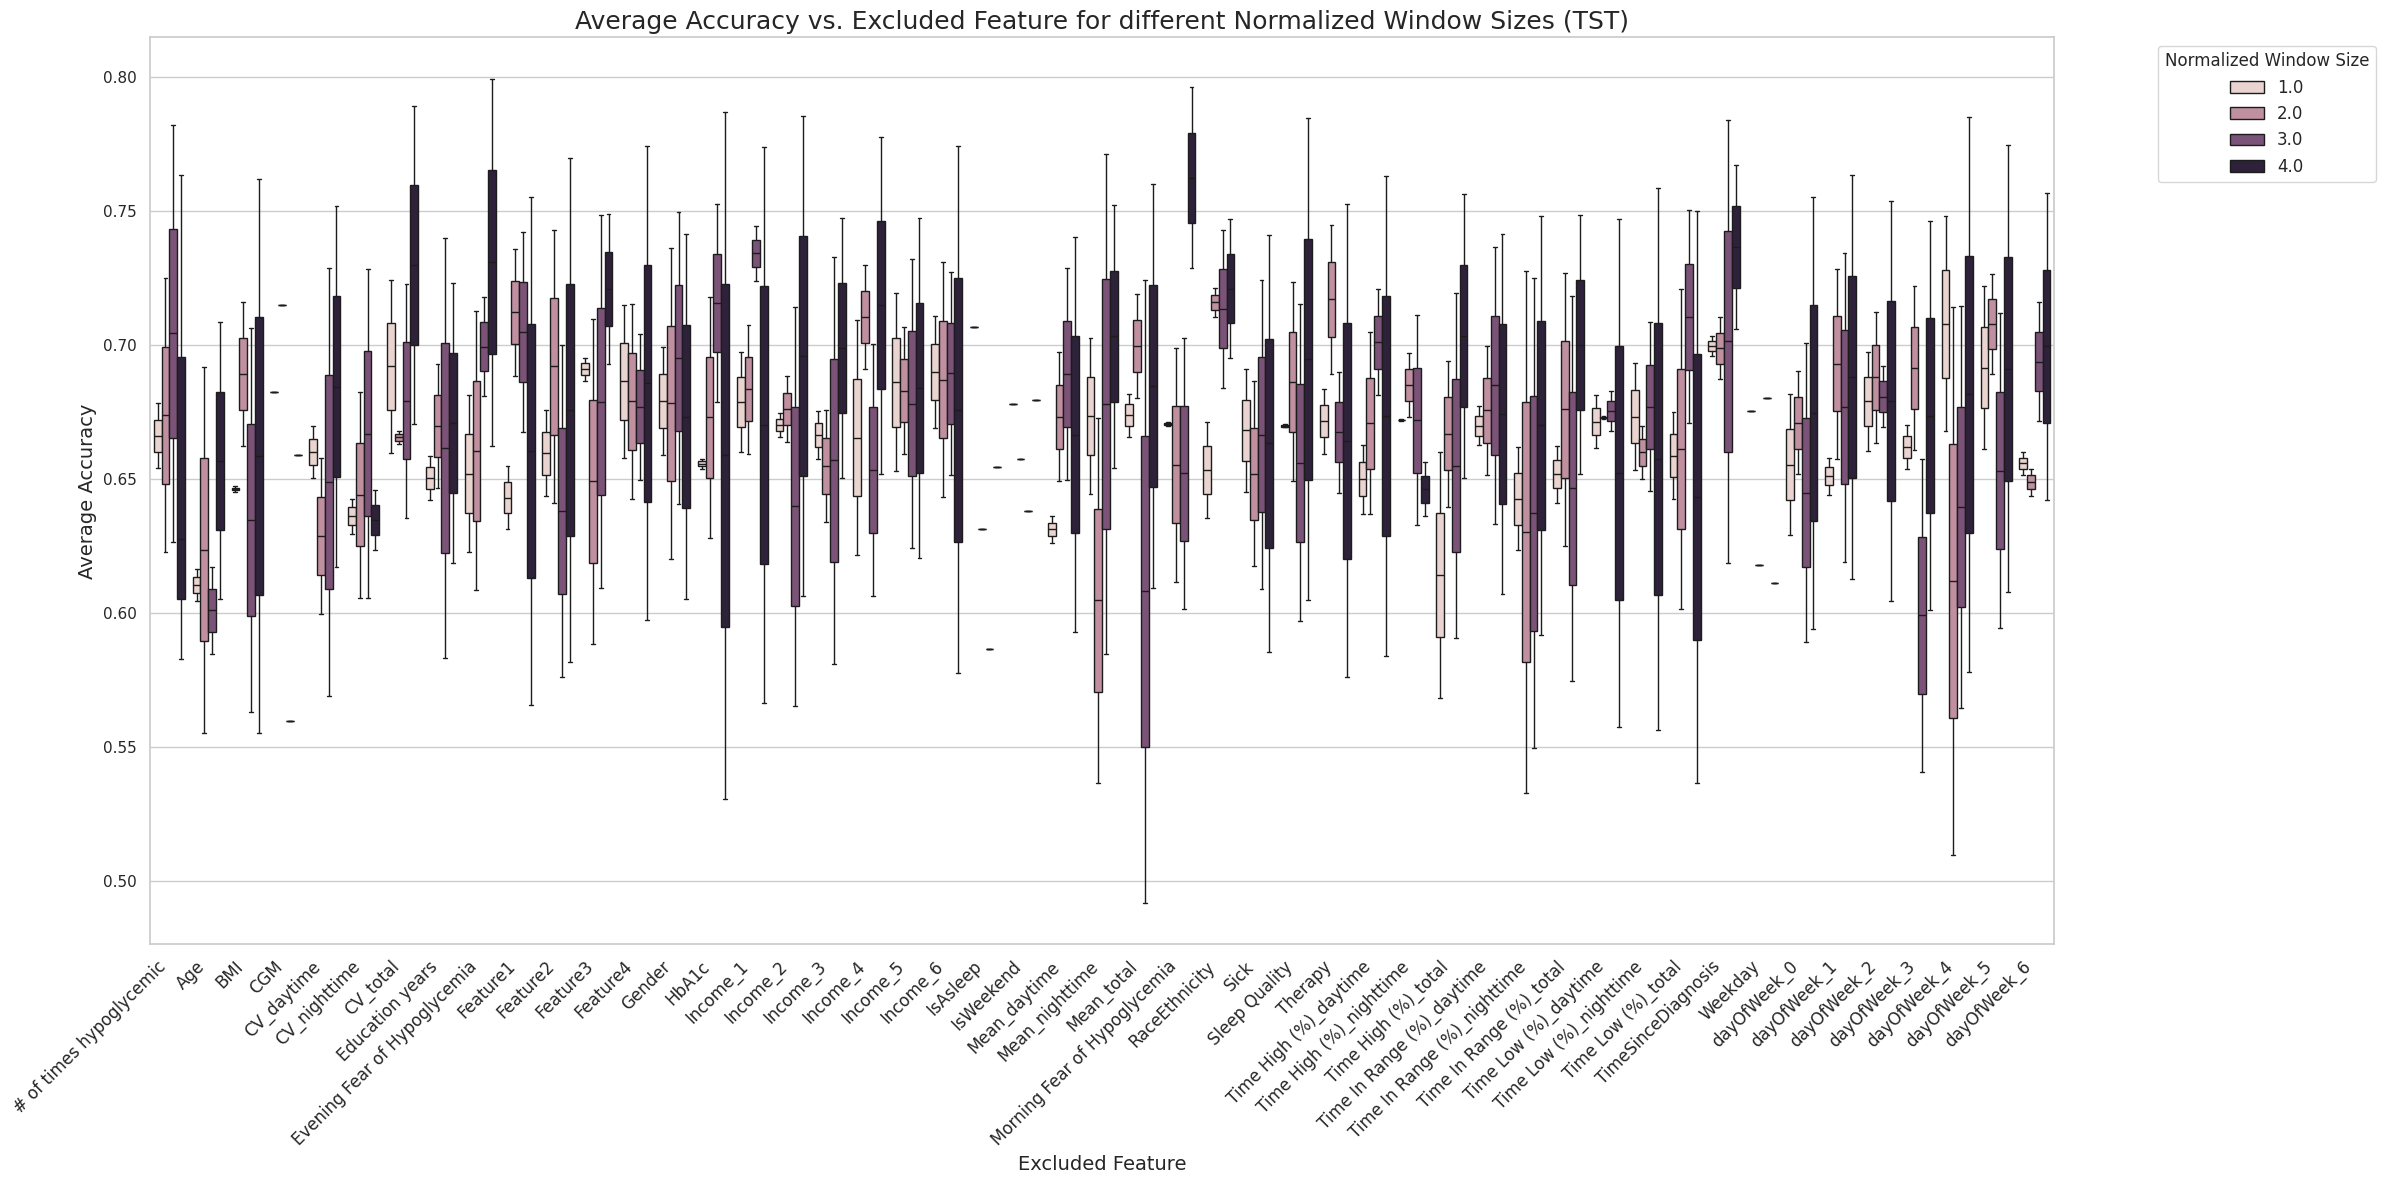

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming res_df is already loaded with the correct data
# Filter out rows that start with 'Participant_'
res_df = res_df[~res_df['Excluded Feature'].str.startswith('Participant_')].copy()

# Normalize window size
res_df.loc[:, 'Normalized Window Size'] = res_df.apply(
    lambda row: row['Window Size'] if row['Granular Size'] == 'daily' else row['Window Size'] / 24,
    axis=1
)

# Convert 'Average Accuracy' and 'Standard Deviation' to numeric
res_df.loc[:, 'Average Accuracy'] = pd.to_numeric(res_df['Average Accuracy'], errors='coerce')
res_df.loc[:, 'Standard Deviation'] = pd.to_numeric(res_df['Standard Deviation'], errors='coerce')

# Drop any rows with NaN values that couldn't be converted
res_df.dropna(inplace=True)

# Set plot style
sns.set(style="whitegrid")

# Increase figure size for better readability
plt.figure(figsize=(24, 12))

# Box plot of Average Accuracy vs. Excluded Feature for different Normalized Window Sizes
sns.boxplot(data=res_df, x='Excluded Feature', y='Average Accuracy', hue='Normalized Window Size')

# Adjust title and labels
plt.title('Average Accuracy vs. Excluded Feature for different Normalized Window Sizes (TST)', fontsize=18)
plt.xlabel('Excluded Feature', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.legend(title='Normalized Window Size', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(rotation=45, fontsize=12, ha='right')

# Show plot
plt.tight_layout()
plt.show()


## Mamba Results

In [ ]:
# Define the DataFrame to store results
res_df_mamba = pd.DataFrame(columns=['Window Size', 'Excluded Feature', 'Granular Size', 'Average Accuracy', 'Standard Deviation'])

def train_and_evaluate_model_mamba(df, window_size, granular_size, exclude_feature=None):
    sequences_np, labels_np, participant_groups = generate_data_with_window(df, window_size, exclude_feature)
    feature_size = sequences_np.shape[2]  # Updated dynamically based on left-out features

    # Ensure all data is float32 for compatibility with PyTorch
    sequences_np = sequences_np.astype(np.float32)
    labels_np = labels_np.astype(np.int64)

    # Instantiate the model with the dynamic number of features
    mamba_model = TimeSeriesMamba(feature_size=feature_size, num_hidden=128, num_layers=3, num_classes=2).to("cuda")

    # Define 5-fold cross-validation with GroupKFold
    gkf = GroupKFold(n_splits=5)

    fold_accuracies = []
    cm_sum = np.zeros((2, 2), dtype=np.int64)

    for fold, (train_idx, val_idx) in enumerate(gkf.split(sequences_np, labels_np, participant_groups), 1):
        X_train_fold, y_train_fold = sequences_np[train_idx], labels_np[train_idx]
        X_val_fold, y_val_fold = sequences_np[val_idx], labels_np[val_idx]

        # Flatten X_train_fold for SMOTE
        X_train_fold_flattened = X_train_fold.reshape(X_train_fold.shape[0], -1)
        smote = SMOTE(random_state=42)
        X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold_flattened, y_train_fold)
        X_train_fold_res = X_train_fold_resampled.reshape(-1, window_size, feature_size)

        # Convert to PyTorch tensors, ensuring all data is on the CUDA device
        train_X_fold = torch.tensor(X_train_fold_res, dtype=torch.float32).to("cuda")
        train_y_fold = torch.tensor(y_train_fold_resampled, dtype=torch.long).to("cuda")
        val_X_fold = torch.tensor(X_val_fold, dtype=torch.float32).to("cuda")
        val_y_fold = torch.tensor(y_val_fold, dtype=torch.long).to("cuda")

        # Train and evaluate the model
        train_losses, val_losses = train_model(mamba_model, train_X_fold, train_y_fold, val_X_fold, val_y_fold, epochs=100, lr=0.001, patience=20)
        test_accuracy, predicted_labels = evaluate_accuracy(mamba_model, val_X_fold, val_y_fold)

        fold_accuracies.append(test_accuracy)
        cm = confusion_matrix(val_y_fold.cpu().numpy(), predicted_labels.cpu().numpy())
        cm_sum += cm

    average_accuracy = np.mean(fold_accuracies)
    std_dev = np.std(fold_accuracies)

    print(f"Accuracy for window {window_size} excluding '{exclude_feature}': {average_accuracy:.4f} ± {std_dev:.4f}")

    result = {
        'Window Size': window_size,
        'Excluded Feature': exclude_feature,
        'Granular Size': granular_size,
        'Average Accuracy': f"{average_accuracy:.4f}",
        'Standard Deviation': f"{std_dev:.4f}"
    }
    return result

In [ ]:
# Example usage in the outer loop
granular_sizes = ["hourly", "daily"]
for indx, curr_df in enumerate([df_one_hour, df]):
  for window_size in [1,2,3,4]:  # Example window sizes
      for feature in curr_df.columns.difference(['Day', 'Participant', 'y']):
        if feature.startswith("Participant_"):
          continue
        print(f"Processing with window size {window_size} days at granular {granular_sizes[indx]} and excluding {feature}")
        if "hourly" in granular_sizes[indx]:
          result = train_and_evaluate_model_mamba(curr_df, window_size * 24, granular_sizes[indx], exclude_feature=feature)
        else:
          result = train_and_evaluate_model_mamba(curr_df, window_size, granular_sizes[indx], exclude_feature=feature)

        res_df_mamba = pd.concat([res_df_mamba, pd.DataFrame([result])], ignore_index=True)
res_df_mamba

Processing with window size 1 days at granular hourly and excluding # of times hypoglycemic
Accuracy for window 24 excluding '# of times hypoglycemic': 0.6403 ± 0.1997
Processing with window size 1 days at granular hourly and excluding Age
Accuracy for window 24 excluding 'Age': 0.5129 ± 0.1348
Processing with window size 1 days at granular hourly and excluding BMI
Accuracy for window 24 excluding 'BMI': 0.6268 ± 0.1918
Processing with window size 1 days at granular hourly and excluding CGM
Accuracy for window 24 excluding 'CGM': 0.5849 ± 0.2159
Processing with window size 1 days at granular hourly and excluding CV_daytime
Accuracy for window 24 excluding 'CV_daytime': 0.4459 ± 0.1173
Processing with window size 1 days at granular hourly and excluding CV_nighttime
Accuracy for window 24 excluding 'CV_nighttime': 0.6100 ± 0.1522
Processing with window size 1 days at granular hourly and excluding CV_total
Accuracy for window 24 excluding 'CV_total': 0.5948 ± 0.1906
Processing with window

,Window Size,Excluded Feature,Granular Size,Average Accuracy,Standard Deviation
0,24,# of times hypoglycemic,hourly,0.6403,0.1997
1,24,Age,hourly,0.5129,0.1348
2,24,BMI,hourly,0.6268,0.1918
3,24,CGM,hourly,0.5849,0.2159
4,24,CV_daytime,hourly,0.4459,0.1173
...,...,...,...,...,...
371,4,dayOfWeek_2,daily,0.6754,0.0680
372,4,dayOfWeek_3,daily,0.6214,0.1183
373,4,dayOfWeek_4,daily,0.6480,0.0722
374,4,dayOfWeek_5,daily,0.6673,0.0528


In [ ]:
res_df_mamba.to_csv("model_exploration_mamba.csv")
res_df_mamba

,Window Size,Excluded Feature,Granular Size,Average Accuracy,Standard Deviation
0,24,# of times hypoglycemic,hourly,0.6403,0.1997
1,24,Age,hourly,0.5129,0.1348
2,24,BMI,hourly,0.6268,0.1918
3,24,CGM,hourly,0.5849,0.2159
4,24,CV_daytime,hourly,0.4459,0.1173
...,...,...,...,...,...
371,4,dayOfWeek_2,daily,0.6754,0.0680
372,4,dayOfWeek_3,daily,0.6214,0.1183
373,4,dayOfWeek_4,daily,0.6480,0.0722
374,4,dayOfWeek_5,daily,0.6673,0.0528


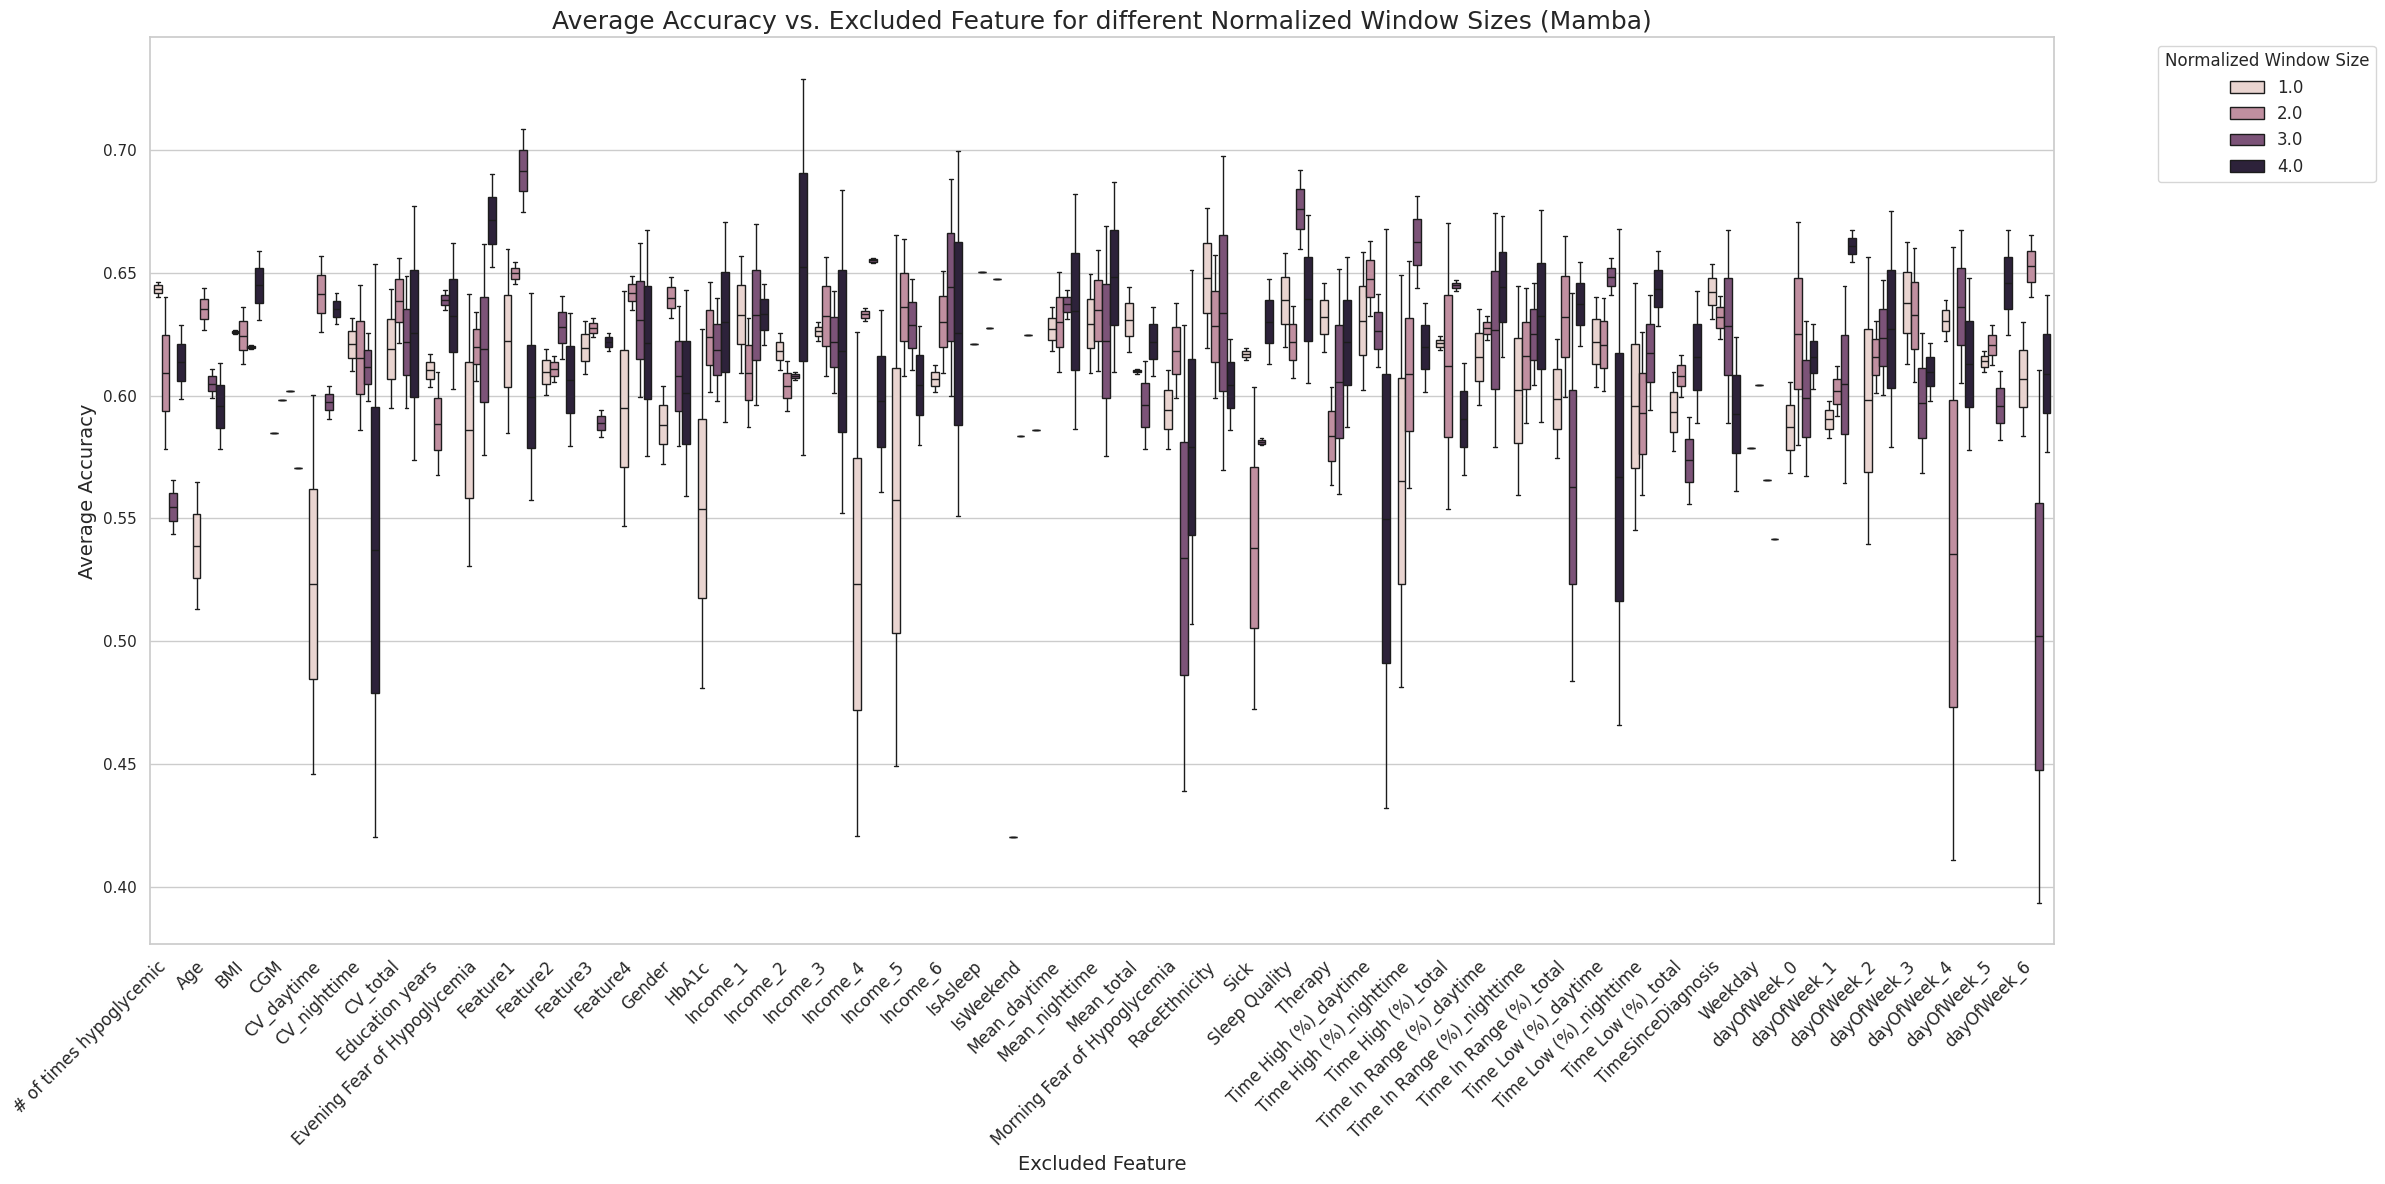

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming res_df_mamba is already loaded with the correct data
# Filter out rows that start with 'Participant_'
res_df_mamba = res_df_mamba[~res_df_mamba['Excluded Feature'].str.startswith('Participant_')].copy()

# Normalize window size
res_df_mamba.loc[:, 'Normalized Window Size'] = res_df_mamba.apply(
    lambda row: row['Window Size'] if row['Granular Size'] == 'daily' else row['Window Size'] / 24,
    axis=1
)

# Convert 'Average Accuracy' and 'Standard Deviation' to numeric
res_df_mamba.loc[:, 'Average Accuracy'] = pd.to_numeric(res_df_mamba['Average Accuracy'], errors='coerce')
res_df_mamba.loc[:, 'Standard Deviation'] = pd.to_numeric(res_df_mamba['Standard Deviation'], errors='coerce')

# Drop any rows with NaN values that couldn't be converted
res_df_mamba.dropna(inplace=True)

# Set plot style
sns.set(style="whitegrid")

# Increase figure size for better readability
plt.figure(figsize=(24, 12))

# Box plot of Average Accuracy vs. Excluded Feature for different Normalized Window Sizes
sns.boxplot(data=res_df_mamba, x='Excluded Feature', y='Average Accuracy', hue='Normalized Window Size')

# Adjust title and labels
plt.title('Average Accuracy vs. Excluded Feature for different Normalized Window Sizes (Mamba)', fontsize=18)
plt.xlabel('Excluded Feature', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.legend(title='Normalized Window Size', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(rotation=45, fontsize=12, ha='right')

# Show plot
plt.tight_layout()
plt.show()
